In [298]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm

import corner
import copy

# Setup

In [373]:
class HMC():
    """
    Hamiltonian Monte Carlo sampler
    https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
    """
    
    def __init__(self, logp, dlogp, dt, L, M, n_args):
        """
        Arguments:
            logp: 
                Function which accepts two inputs (args, data) and returns log
                probability of the objective model
                
            dlogp:
                Function which which accepts two inputs (args, data) and returns the
                gradient of the log probability w.r.t. the parameters as a np array
                
            dt: Time step
            
            L: Number of leapfrog iterations to calculate
            
            M: covariance of momentum sampling multivariate normal
            
            n_args: number of parameters to sample
        """
        self.logp = logp
        self.dlogp = dlogp
        self.dt = dt
        self.L = L
        self.M = M
        self.n_args = n_args
    
    def U(self, x, data):
        return -self.logp(x,data)
    
    def dU(self, x, data):
        return -self.dlogp(x,data)
    def K(self, v):
        return -mvnorm.logpdf(v, mean=np.zeros(self.n_args), cov=self.M)
    
    def proposal(self, x, v, data):
        # Leapfrog
        # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
        x, v = copy.deepcopy((x,v))
        
        for _ in range(self.L):
            v -= (self.dt/2)*self.dU(x, data)
            x += self.dt*np.dot(np.linalg.inv(self.M), v)
            v -= (self.dt/2)*self.dU(x, data)
        
        return x, v
    
    def sample(self, N_samp, data, init_x=None):
        if init_x==None:
            x = 2*np.random.rand(self.n_args)-0.5
        else:
            x = init_x
            
        xs = np.zeros(shape=(N_samp, self.n_args))
        xs[0] = x
        
        for i in range(1, N_samp):
            v = mvnorm.rvs(mean=np.zeros(self.n_args), cov=self.M)

            xnew, vnew = self.proposal(x, v, data)

            alpha = np.exp(self.U(x, data) +  self.K(v)
                           - self.U(xnew, data) - self.K(vnew))

            if np.random.rand() <= min(1, alpha):
                xs[i] = xnew
                x = xnew
            else:
                xs[i] = xs[i-1]
                
        return xs

# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [410]:
# Generate observed data
truth = (0,1)

N = 100000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)

print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: -0.002859435471150335, sig_hat: 1.0000433232420638


In [411]:
# Define Model

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    if args[1] <= 0:
        return 0
    return np.sum(norm.logpdf(data, *args))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu, sig = args
    dmu = np.sum((data - mu)/(sig**2))
    dsig = np.sum((mu**2 - sig**2 - 2*mu*data + data**2)/(sig**3))
    return np.array([dmu, dsig])

In [412]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2)

In [413]:
# Run sampling
xs = sampler.sample(int(1e4), data, init_x=[0.1,0.5])

/Users/maho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


In [414]:
# Burn
xs = xs[100:]

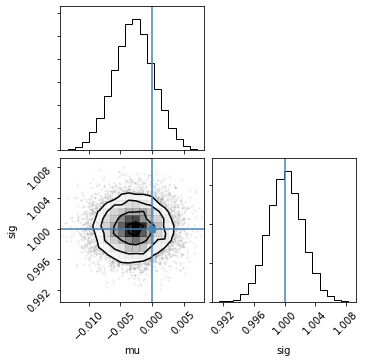

In [415]:
# Corner plot
f = corner.corner(xs, truths=truth, labels=['mu', 'sig'])

(0, 9900)

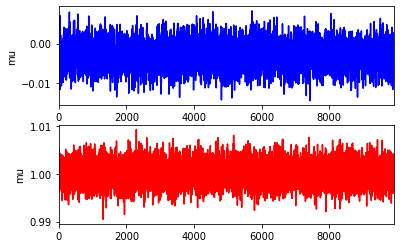

In [416]:
# Trace

f, axs = plt.subplots(2,1)

axs[0].plot(xs[:,0], label='mu', color='b')
axs[0].set_ylabel('mu')
axs[0].set_xlim(0,len(xs))


axs[1].plot(xs[:,1], label='sig', color='r')
axs[1].set_ylabel('mu')
axs[1].set_xlim(0,len(xs))

# Scratch